#  Completeness and Purity - DC2 with RedMaPPer - NumCosmo

---
**License**

 Completeness and Purity - DC2 with RedMaPPer - NumCosmo

 Mon Jan 13 14:30:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---
 completeness_purity\
 Copyright (C) 2025 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [2]:
import sys

import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd

sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/MachingCatalogs")

import GCRCatalogs
#Put nersc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

# GCRCatalogs.get_available_catalog_names()

GCRCatalogs = 1.9.0 | GCR = 0.9.2


In [3]:
import clevar
from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
from clevar.match import output_matched_catalog
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf


## Catalogs

In [4]:
# #Cosmo DC2
# cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

# #Cosmo DC2 + RedMaPPer
# catalog_dc2_redmapper = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')

In [5]:
# # Restrictions on richness, mass and redshift
# min_richness = 0
# min_halo_mass = 1e13 #Msunmmm
# redshift_max = 1.2

# #cDC2 + RM data
# quantities = catalog_dc2_redmapper.list_all_quantities()
# cluster_quantities = [q for q in quantities if 'member' not in q]
# member_quantities = [q for q in quantities if 'member' in q]
    
# query = GCRCatalogs.GCRQuery('(richness > ' + str(min_richness) +')')
# cluster_data = Table(catalog_dc2_redmapper.get_quantities(cluster_quantities, [query])) # cDC2 + RM cluster data
# member_data = Table(catalog_dc2_redmapper.get_quantities(member_quantities)) # cDC2 + RM member data

# #cDC2 data
# quantities_wanted = ['redshift','halo_mass','halo_id','galaxy_id','ra','dec', 'is_central']
# query = GCRCatalogs.GCRQuery('(halo_mass > ' + str(min_halo_mass) +') & (redshift < ' + str(redshift_max) +') & (is_central < ' + str(redshift_max) +') ')
# truth_data = Table(cosmodc2.get_quantities(quantities_wanted, [query]))

cluster_data = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cluster_data.fits')
member_data = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/member_data.fits')
truth_data = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/truth_data.fits')

In [5]:
# cluster_data

In [6]:
truthdf = truth_data.to_pandas().rename(columns={'galaxy_id': 'id'})

halo_g = truthdf.groupby('halo_id')

halo_data = pd.DataFrame(data = {'halo_id':[], 'halo_mass': [], 'halo_redshift': []})
                                 
for ha in truthdf['halo_id'].unique():
    halo_mass =  halo_g.get_group(ha)['halo_mass'].iloc[0]
    halo_redshift = np.mean(halo_g.get_group(ha)[['redshift']])

    data = pd.DataFrame([{'halo_id': ha, 'halo_mass': halo_mass, 'halo_redshift': halo_redshift}])                
    
    halo_data = pd.concat([halo_data, data], ignore_index=True)

In [65]:
mdata = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/match_proximity.fits')


In [66]:
test_matchdata = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/match_ID.fits')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["cluster_redshift"]
mass_data = test_matchdata["halo_mass"]

mt_data2 = Table([mass_data, rich_data, z_data], names=('mass', 'R', 'z'))


In [27]:
# CLEVAR

min_richness = 5
min_halo_mass = 1e13 #Msun

# Halos/Clusters
#CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/RM_cat.fits', name='RM_cat', full=True) #tags={'mass':'richness'}

#CosmoDC2: 'cosmoDC2_v1.1.4_image'
halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/halo_cat.fits', name='halo_cat', full=True) #tags={'mass':'mass_fof'}

#Members
RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/RM_cat_members.fits',  full=True)
halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/halo_cat_members.fits', full=True)

#Match catalogs
mt = MembershipMatch()

mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/')
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'self')

RM_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    45,081
 * multiple (self):  43,106
 * multiple (other): 43,106
 * unique (self):    42,914
 * unique (other):   42,917
 * cross:            42,914

halo_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    249,557
 * multiple (self):  74,474
 * multiple (other): 74,474
 * unique (self):    42,917
 * unique (other):   42,914
 * cross:            42,914


In [28]:
RM_cat_bij

id,z,ra,dec,mass,richness_err,id_cg,ztrue_cg,p_cg_0,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_frac_self,mt_frac_other,mt_cross
str11,float32,float64,float64,float32,float32,int64,float32,float32,object,object,object,object,float64,float64,object
10,0.5135129,52.520436430812914,-25.717996124671657,190.70665,3.7469666,1312945563,0.51072353,0.79138356,1162500021323,1162500021323,"['665600021315', '1361100021315', '205900021323', '80500021323', '711400021315', '417800021323', '1162500021323', '922700021315']","['1361100021315', '205900021323', '80500021323', '711400021315', '417800021323', '1162500021323', '665600021315', '922700021315']",0.4496726208984491,0.30094043887147337,1162500021323
18,0.5712697,56.920376528125075,-27.20434071042304,179.12813,3.6934361,2000524808,0.5740297,0.99996513,549500032315,549500032315,['549500032315'],['549500032315'],0.9421648861882373,0.35064935064935066,549500032315
24,1.040338,56.99849698116052,-26.7172081871169,124.02715,2.4172914,2002535198,1.0347759,0.93527913,2554900032241,2554900032241,"['1212700032259', '2554900032241', '3011300032241']","['1212700032259', '2554900032241', '3011300032241']",0.9468829847683286,0.28444444444444444,2554900032241
30,0.63518524,58.56362402841767,-27.429961828331713,167.33603,3.6777163,2000759779,0.6426174,0.9958548,1275900032300,1275900032300,"['23400032300', '6600032300', '1275900032300']","['23400032300', '6600032300', '1275900032300']",0.9812835255072209,0.2767857142857143,1275900032300
71,0.44230303,58.35519782866568,-26.867687128773035,111.9147,3.366554,2000289335,0.43919736,0.7297119,564000032338,564000032338,"['359200032338', '161400032338', '731900032338', '564000032338', '778100032338', '243000032347']","['359200032338', '161400032338', '731900032338', '564000032338', '778100032338', '243000032347']",0.5346957617359577,0.2518518518518518,564000032338
73,0.46697217,57.76575707007693,-28.119101936484828,104.439766,2.9570596,2000290819,0.4680865,0.99970347,459400032338,459400032338,"['980800032331', '2200032331', '459400032338']","['980800032331', '2200032331', '459400032338']",0.9046435837281485,0.2780612244897959,459400032338
109,0.4413634,58.509466974185045,-26.989676182075844,103.49396,3.3524604,2000286447,0.44349608,0.99999905,156700032338,156700032338,"['156700032338', '433200032355']","['156700032338', '433200032355']",0.9589822433529834,0.28672985781990523,156700032338
116,1.0629631,54.494027152041674,-27.896589555863095,76.85877,2.2175314,1940324795,1.0758829,0.6544826,3080200031235,3080200031235,"['2468800031230', '3080200031235']","['2468800031230', '3080200031235']",0.9300718737691595,0.2791519434628975,3080200031235
133,1.037697,58.137368555958155,-27.199784884537003,75.89771,2.26323,2002528355,1.0311339,0.991116,2067100032241,2067100032241,"['1539400032241', '2412900032235', '2067100032241', '1231200032230']","['1231200032230', '1539400032241', '2412900032235', '2067100032241']",0.9547645155057961,0.29213483146067415,2067100032241


In [14]:
RM_cat_bij_other, halo_cat_bij_other = get_matched_pairs(RM_cat, halo_cat, 'other')
RM_cat_bij_cross, halo_cat_bij_cross = get_matched_pairs(RM_cat, halo_cat, 'cross')

diff = np.isin(RM_cat_bij_other['id'], RM_cat_bij_cross['id'], invert=True)

RM_cat_bij_other[diff]

id,z,ra,dec,mass,richness_err,id_cg,ztrue_cg,p_cg_0,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_frac_self,mt_frac_other,mt_cross
str11,float32,float64,float64,float32,float32,int64,float32,float32,object,object,object,object,float64,float64,object
36779,1.1018943,64.1539926876899,-26.163777500759423,6.060438,1.2709843,1565595908,1.1107318,0.9725479,None,1214300025241,"['1214300025241', '2454300025230']","['1214300025241', '2454300025230']",0.0,1.0,None
6679,0.8118417,75.23254893312459,-29.720579159016125,5.7248287,2.0537908,3751375740,0.8197346,0.8442593,None,2191200060272,"['1817100060286', '2191200060272', '967300060266', '2604000060272']","['967300060266', '1817100060286', '2191200060272', '2604000060272']",0.0,0.16883116883116883,None
35507,0.49879035,58.96389653258708,-38.01710915885276,5.663809,1.1600951,7875432615,0.500419,0.81199914,None,248900126338,"['676200126323', '248900126338']","['676200126323', '248900126338']",0.0,0.047619047619047616,None


In [13]:
RM_cat_bij

id,z,ra,dec,mass,richness_err,id_cg,ztrue_cg,p_cg_0,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_frac_self,mt_frac_other,mt_cross
str11,float32,float64,float64,float32,float32,int64,float32,float32,object,object,object,object,float64,float64,object
10,0.5135129,52.520436430812914,-25.717996124671657,190.70665,3.7469666,1312945563,0.51072353,0.79138356,1162500021323,1162500021323,"['665600021315', '1361100021315', '205900021323', '80500021323', '711400021315', '417800021323', '1162500021323', '922700021315']","['1361100021315', '205900021323', '80500021323', '711400021315', '417800021323', '1162500021323', '665600021315', '922700021315']",0.4496726208984491,0.30094043887147337,1162500021323
18,0.5712697,56.920376528125075,-27.20434071042304,179.12813,3.6934361,2000524808,0.5740297,0.99996513,549500032315,549500032315,['549500032315'],['549500032315'],0.9421648861882373,0.35064935064935066,549500032315
24,1.040338,56.99849698116052,-26.7172081871169,124.02715,2.4172914,2002535198,1.0347759,0.93527913,2554900032241,2554900032241,"['1212700032259', '2554900032241', '3011300032241']","['1212700032259', '2554900032241', '3011300032241']",0.9468829847683286,0.28444444444444444,2554900032241
30,0.63518524,58.56362402841767,-27.429961828331713,167.33603,3.6777163,2000759779,0.6426174,0.9958548,1275900032300,1275900032300,"['23400032300', '6600032300', '1275900032300']","['23400032300', '6600032300', '1275900032300']",0.9812835255072209,0.2767857142857143,1275900032300
71,0.44230303,58.35519782866568,-26.867687128773035,111.9147,3.366554,2000289335,0.43919736,0.7297119,564000032338,564000032338,"['359200032338', '161400032338', '731900032338', '564000032338', '778100032338', '243000032347']","['359200032338', '161400032338', '731900032338', '564000032338', '778100032338', '243000032347']",0.5346957617359577,0.2518518518518518,564000032338
73,0.46697217,57.76575707007693,-28.119101936484828,104.439766,2.9570596,2000290819,0.4680865,0.99970347,459400032338,459400032338,"['980800032331', '2200032331', '459400032338']","['980800032331', '2200032331', '459400032338']",0.9046435837281485,0.2780612244897959,459400032338
109,0.4413634,58.509466974185045,-26.989676182075844,103.49396,3.3524604,2000286447,0.44349608,0.99999905,156700032338,156700032338,"['156700032338', '433200032355']","['156700032338', '433200032355']",0.9589822433529834,0.28672985781990523,156700032338
116,1.0629631,54.494027152041674,-27.896589555863095,76.85877,2.2175314,1940324795,1.0758829,0.6544826,3080200031235,3080200031235,"['2468800031230', '3080200031235']","['2468800031230', '3080200031235']",0.9300718737691595,0.2791519434628975,3080200031235
133,1.037697,58.137368555958155,-27.199784884537003,75.89771,2.26323,2002528355,1.0311339,0.991116,2067100032241,2067100032241,"['1539400032241', '2412900032235', '2067100032241', '1231200032230']","['1231200032230', '1539400032241', '2412900032235', '2067100032241']",0.9547645155057961,0.29213483146067415,2067100032241


In [24]:
mt_data3 = Table([RM_cat_bij['id'], halo_cat_bij['id'],halo_cat_bij['mass'], RM_cat_bij['mass'], RM_cat_bij['z']], names=('cluster_id', 'halo_id','mass', 'R', 'z'))
# dt_halos = clusters_dt[np.logical_and(clusters_dt['redshift_true'] > 0.14, clusters_dt['redshift_true']< 0.33)]
# dt_halos = dt_halos[dt_halos['richness'] > 20]
# dt_halos = clusters_dt

# mt_data3 = Table([halo_cat_bij['mass_fof'], halo_cat_bij['z'], halo_cat_bij['ra'], halo_cat_bij['dec'],
#                   RM_cat_bij['richness'], RM_cat_bij['richness_err'], RM_cat_bij['z'], RM_cat_bij['ra'], RM_cat_bij['dec']], 
#                  names=('halo_mass', 'redshift', 'ra', 'dec', 'richness', 'richness_err', 'cluster_redshift', 'cluster_ra', 'cluster_dec'))

mt_data3 = mt_data3.to_pandas()


## Completeness

The **completeness** ($c(M, z)$) of a cluster catalog is defined as the fraction of true galaxy clusters correctly identified by the algorithm within a specific mass range ($M$)  and redshift ($z$). It is calculated as follows ([Aguena, Lima 2016](
https://doi.org/10.48550/arXiv.1611.05468
)):

$$
c(M, z) = \frac{N_{\text{mat}}(M, z)}{N_h(M, z)}
$$

Where:  
$N_{\text{mat}}(M, z)$ : Number of halos with mass ($M$) and redshift ($z$) that were correctly matched to clusters detected in the catalog.  
$N_h(M, z)$: Total number of halos with mass ($M$) and redshift ($z$) present in the dataset.

In [69]:
def completeness(halos, clusters, bin_range = None, bins = None) :

    hist_matches = np.histogram2d(clusters['z'], np.log10(clusters['mass']),range=bin_range, bins= bins)
    N_matches = hist_matches[0]
    # print(N_matches)
    
    hist_halos = np.histogram2d(halos["halo_redshift"],np.log10(halos['halo_mass']),range=bin_range, bins= bins)
    N_halos = hist_halos[0]
    # print(N_halos)
    
    complet =  N_matches / N_halos 
           
    return complet


/tmp/ipykernel_1290923/3195316643.py:11: RuntimeWarning: invalid value encountered in divide
  complet =  N_matches / N_halos


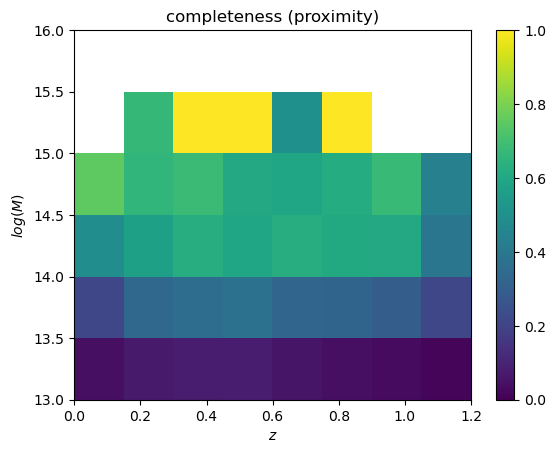

In [70]:
bin_range = [[0.0,1.2],[13.,16]]
bins = [8,6]

complet = completeness(halo_data, mdata, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(complet.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(M)$')

ax.set_title('completeness (proximity)')

plt.show()

/tmp/ipykernel_1290923/3195316643.py:11: RuntimeWarning: invalid value encountered in divide
  complet =  N_matches / N_halos


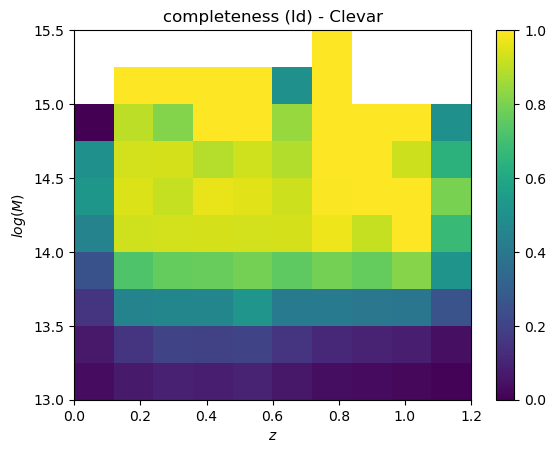

In [71]:
bin_range = [[0.0,1.2],[13.,15.5]]
bins = [10,10]

complet = completeness(halo_data, mt_data3, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(complet.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(M)$')

ax.set_title('completeness (Id) - Clevar')

plt.show()

/tmp/ipykernel_1290923/3195316643.py:11: RuntimeWarning: invalid value encountered in divide
  complet =  N_matches / N_halos


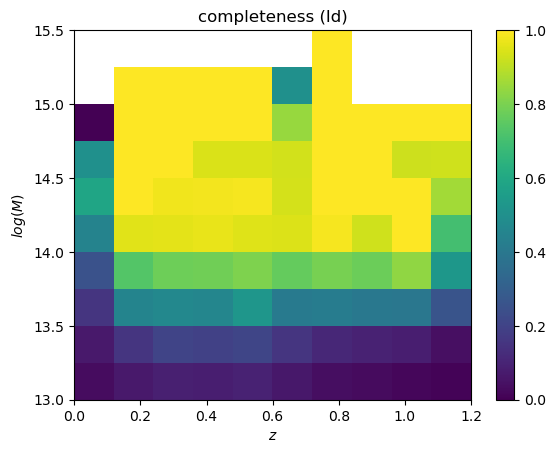

In [72]:
bin_range = [[0.0,1.2],[13.,15.5]]
bins = [10,10]

complet = completeness(halo_data, mt_data2, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(complet.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(M)$')

ax.set_title('completeness (Id)')

plt.show()

## Purity

**Purity** ( $ p(\lambda, z)$ ) measures the fraction of detected clusters that correspond to true halos, serving as a metric to avoid false positives in the catalog. It is calculated as ([Aguena, Lima 2016](
https://doi.org/10.48550/arXiv.1611.05468
)):

$$
p(M, z) = \frac{N_{\text{mat}}(\lambda, z)}{N_c(\lambda, z)}
$$

Where:  
$ N_{\text{mat}}(\lambda, z)$: Number of detected clusters that are correctly matched to true dark matter halos.  
$ N_c(\lambda, z) $: Total number of clusters detected by the algorithm within an observed richness range $\lambda$ and  redshift $z$.

In [73]:
def purity(catalog_clusters, clusters, bin_range = None, bins = None) :

    hist_matches = np.histogram2d(clusters['z'], np.log(clusters['R']),range=bin_range, bins= bins)
    N_matches = hist_matches[0]
    # print(N_matches)
    
    hist_c = np.histogram2d(catalog_clusters["cluster_redshift"],np.log(catalog_clusters['richness']),range=bin_range, bins= bins)
    N_c = hist_c[0]
    # print(N_c)
    
    purit =  N_matches / N_c 
           
    return purit


/tmp/ipykernel_1290923/805087121.py:11: RuntimeWarning: invalid value encountered in divide
  purit =  N_matches / N_c


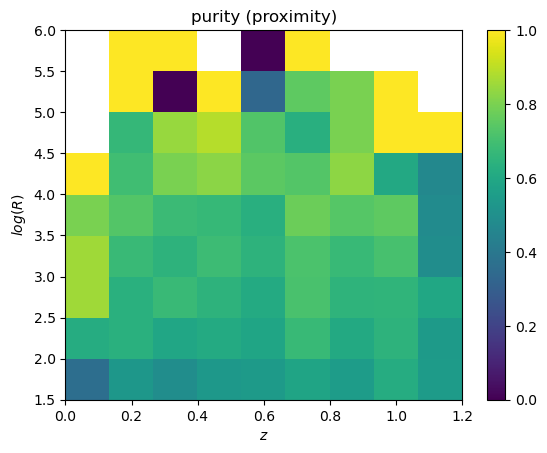

In [74]:
bin_range = [[0, 1.2],[1.5, 6.0]]
bins = [9,9]

pur = purity(cluster_data, mdata, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(pur.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(R)$')

ax.set_title('purity (proximity)')

plt.show()

/tmp/ipykernel_1290923/805087121.py:11: RuntimeWarning: invalid value encountered in divide
  purit =  N_matches / N_c


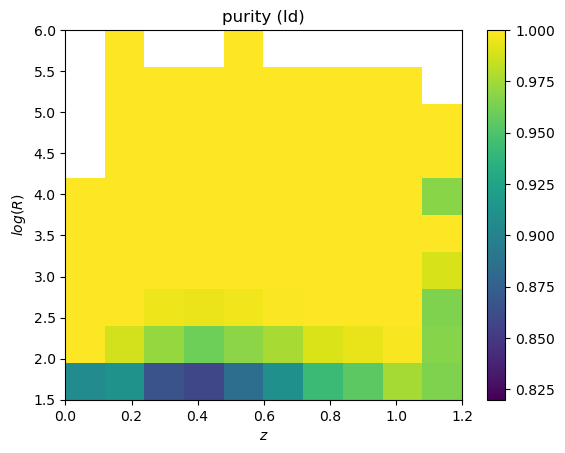

In [75]:
bin_range = [[0, 1.2],[1.5, 6.0]]
bins = [10,10]

pur = purity(cluster_data, mt_data2, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(pur.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0.82, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(R)$')

ax.set_title('purity (Id)')

plt.show()

/tmp/ipykernel_1290923/805087121.py:11: RuntimeWarning: invalid value encountered in divide
  purit =  N_matches / N_c


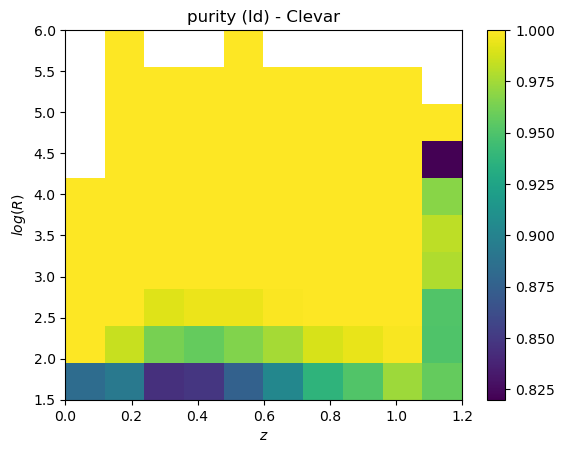

In [55]:
bin_range = [[0, 1.2],[1.5, 6.0]]
bins = [10,10]

from matplotlib.colors import LogNorm

pur = purity(cluster_data, mt_data3, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(pur.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0.82, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(R)$')

ax.set_title('purity (Id) - Clevar')

plt.show()

In [56]:
test_id = test_matchdata[np.logical_and(np.log(test_matchdata['richness']) > 3.7 , np.log(test_matchdata['richness']) < 4.2 )]

test_id = test_id[np.logical_and(test_id['cluster_redshift'] > 1.1 , test_id['cluster_redshift'] < 1.2 )]

test_id

cluster_id,halo_id,halo_redshift,cluster_ra,cluster_dec,richness,richness_err,halo_mass,redshift,cluster_redshift,cluster_redshift_err
int64,int64,float64,float64,float64,float32,float32,float64,float64,float32,float32
360,1810500026224,1.1545501998902412,68.05730522606055,-26.32801978663107,59.31555,2.2767918,187164140558422.53,1.1545501998902412,1.1314876,0.0035982751
460,1886700030230,1.1571031464971346,52.015938509303254,-28.05278780383607,50.894806,2.134983,107547980179830.98,1.1571031464971346,1.1318549,0.003973647
696,2990100077224,1.1632103863359635,49.00157024980271,-31.76930891993833,61.878387,2.73021,211846969776676.06,1.1632103863359635,1.1328292,0.0033179373
995,3214700092230,1.1369453262710527,51.45804576871438,-33.84026348665239,46.898003,2.8389993,255533186148957.75,1.1369453262710527,1.1325066,0.0085057905
979,2343100092224,1.174033524449844,51.158666528914495,-34.200424385217964,40.490913,2.2930572,98274421295594.38,1.174033524449844,1.1330091,0.004247245
480,1924500069230,1.1153124570539537,63.897843647928816,-30.85106289918204,49.506607,2.0113895,132571315993239.44,1.1153124570539537,1.1325246,0.00542803
429,506600071230,1.1373506511575204,69.8429539229386,-31.391579515110415,52.92372,2.3798506,192957951250028.2,1.1373506511575204,1.1294616,0.007868702
395,1918100125230,1.147433989246974,55.926306205931716,-37.93799300397122,55.303497,2.3469532,194985395099042.25,1.147433989246974,1.1321709,0.003447287
691,2466500123235,1.1007810669218094,50.95949804449071,-36.02843006275398,46.303062,2.4472985,578135916174783.1,1.1007810669218094,1.100632,0.010546984


In [57]:
test_clevar = mt_data3[np.logical_and(np.log(mt_data3['R']) > 3.7 , np.log(mt_data3['R']) < 4.2 )]

test_clevar = test_clevar[np.logical_and(test_clevar['z'] > 1.1 , test_clevar['z'] < 1.2 )]

# test_clevar

In [58]:
# set(test_clevar['halo_id']) - set(test_id['halo_id'])

In [59]:
{int(a) for a in test_clevar['cluster_id']} - {int(a) for a in test_id['cluster_id']}


# set(test_clevar['cluster_id']) set(test_id['cluster_id'])


# diference = list(map(int, list(set(test_clevar['cluster_id']) - set(test_id['cluster_id']))))
# len(diference)

{2197}

In [60]:
test_clevar[test_clevar['cluster_id'] == '1736']

cluster_id,halo_id,mass,R,z
str11,str21,float64,float32,float32


In [61]:
cluster_data[cluster_data['cluster_id'] == 1736]

ra_cen_1,ra_cen_3,ra_cen_0,id_cen_1,cluster_id,p_cen_2,id_cen_0,cluster_ra,cluster_redshift,richness_err,p_cen_0,id_cen_2,cluster_dec,p_cen_1,cluster_redshift_err,dec_cen_2,ra_cen_4,dec_cen_0,dec_cen_3,richness,dec_cen_1,maskfrac,id_cen_3,id_cen_4,ra_cen_2,p_cen_3,scaleval,p_cen_4,redshift_true_cg,dec_cen_4
float64,float64,float64,int64,int32,float32,int64,float64,float32,float32,float32,int64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,int64,int64,float64,float32,float32,float32,float32,float64
53.23105480732438,53.23456150592032,53.233116382090074,11003719413,1736,1.0715993e-09,11003719405,53.233116382090074,1.1480688,2.8512337,0.9999999,11003719439,-43.88434311004422,1.1447624e-07,0.0052446635,-43.88389218600875,-400.0,-43.88434311004422,-43.87646781904724,46.287804,-43.884596224123065,0.0,11003719530,11000445129,53.23502070355236,7.705469e-11,1.0000631,0.0,1.2099386,-400.0


In [29]:
test_id[test_id['halo_id'] == '3696200176219']

cluster_id,halo_id,halo_redshift,cluster_ra,cluster_dec,richness,richness_err,halo_mass,redshift,cluster_redshift,cluster_redshift_err
float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32


In [30]:
# test_clevar[test_clevar['cluster_id'].isin(diference)]

In [31]:
# # Use np.isin() to create a boolean mask
# mask = np.isin(test_clevar['cluster_id'], diference)

# # Apply the mask to the table
# filtered_table = test_clevar[mask]

In [32]:
# filtered_table

In [33]:
# test_clevar['cluster_id']

In [34]:
cluster_data = Table.read(

SyntaxError: incomplete input (106048834.py, line 1)